# Least Significant Bit (LSB) Watermarking

Simple and **BLIND** digital watermarking technique.

* BLIND $==$ you do not need the original image to get the watermarking embedding locations. 

* IDEA: embed the watermark most significant bit (MSB) (if you use an array of N elements they are all significant) to the image pixels Less Significant Bit (LSB).

* WHY? (TAKE NOTES) 

* PROS: Invisible

* CONS: Fragile

* USE CASE: Weak Watermarking, Data Hiding

### How does it work the LSB Watermarking embedding?
(Take Notes...)

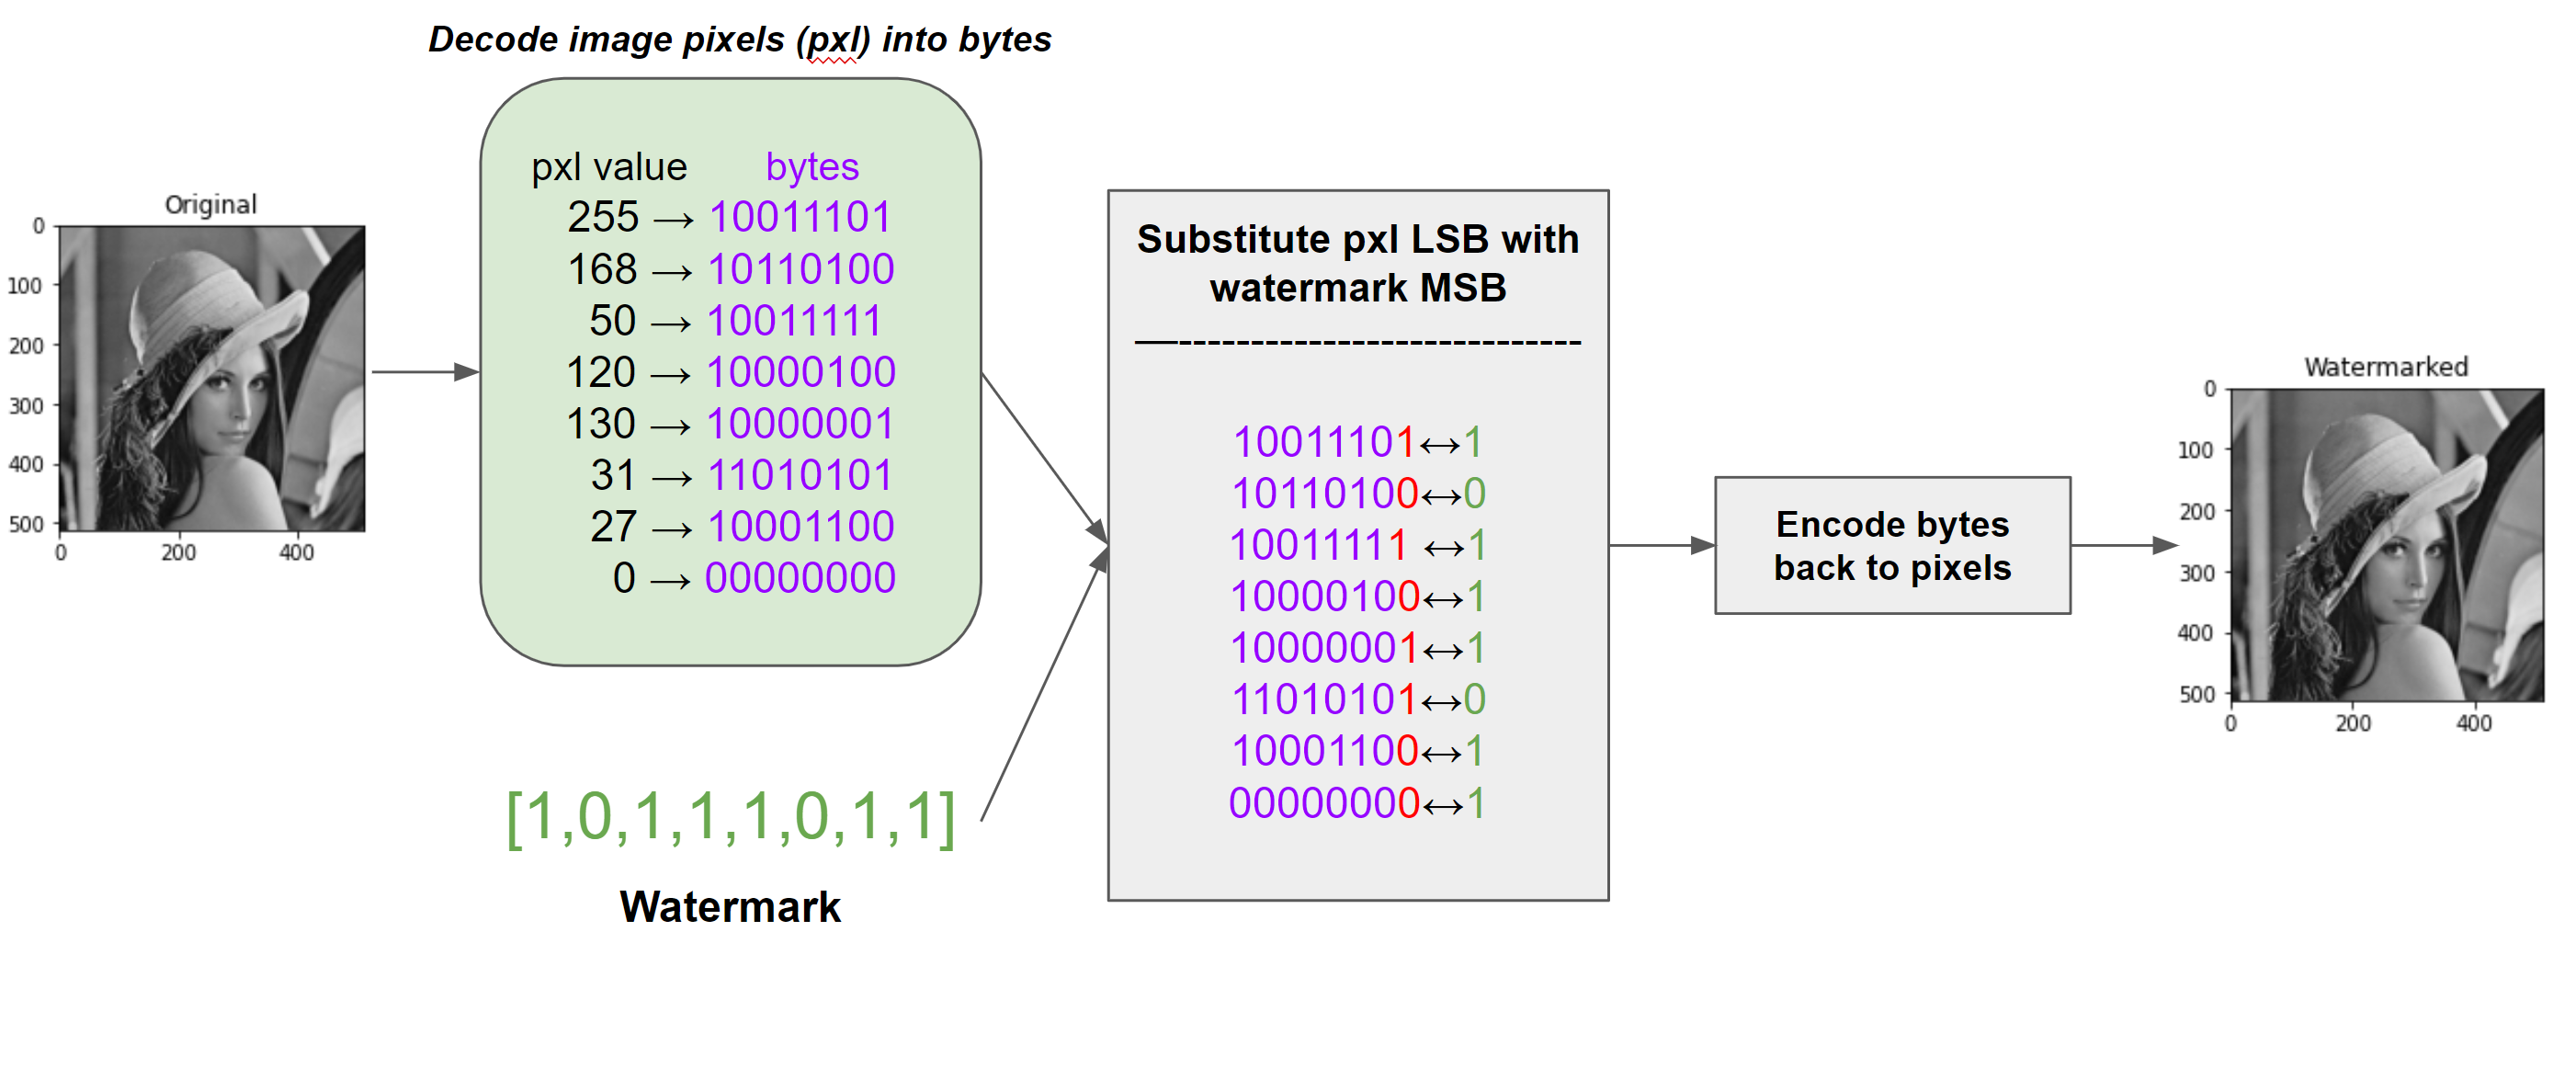



## LSB Watermarking Embedding

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read image 
im = cv2.imread('lena_grey.bmp', 0)
# Check Image Shape
print('Image shape: ', np.shape(im))

#Genetate your watermark
N = 1024 #watermark size
watermark = (np.random.normal(0, 1, N) > 0).astype(int)
print('Watermark: ', watermark)

Image shape:  (512, 512)
Watermark:  [0 0 0 ... 0 0 0]


### Decode Image Pixels into bytes

In [2]:
# Flatted the images for easy embedding
pixels = im.flatten()
flat_im_size = np.shape(pixels)


# Example of decoded pixel value
pixel_format = format(pixels[0], "08b")
print(pixel_format)
print(type(pixel_format))

10100010
<class 'str'>


### Embedding (Substitute pixels LSB with the watermark MSB) + Encoding bytes back to pixels

In [3]:
# Embedding
idx_watermark_bit = 0
for i in range(flat_im_size[0]):
  im_pixel_bytes = format(pixels[i], "08b")

  # concate all the pixels until the LSB from the image
  # and the MSB of the watermark as LSB
  watermarked_data = im_pixel_bytes[:7] + str(watermark[idx_watermark_bit])

  #encoding bytes back to pixels
  pixels[i] = int(watermarked_data, 2)
  idx_watermark_bit += 1
  if idx_watermark_bit > 1023:
     idx_watermark_bit = 0


### Reshape watermarked data (res_flat) back to image

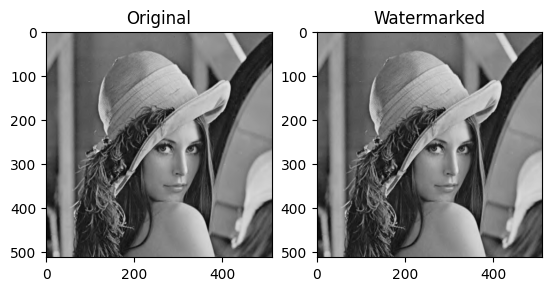

True

In [4]:
# Reshape image
watermarked_img = pixels.reshape(512, 512)

# Show images side by side
plt.subplot(121)
plt.title('Original')
plt.imshow(im, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked_img,cmap='gray')
plt.show()

# save image
cv2.imwrite('watermarked.bmp', watermarked_img)

## Quality

There are several ways to estimate how the watermark embedding (or an attack) deteriorated the resulting image.

### PSNR

One of the most common is the Peak Signal to Noise Ratio (PSNR), which measure the quality of the resulting processed image (watermarked or attacked) compared to the original one

$PSNR = 10 \cdot log_{10} \frac{V_{max}^2}{MSE}$

MSE: average squared difference between the pixels of the original and resulting image



In [5]:
psnr = cv2.PSNR(im, watermarked_img)
print('PSNR: %.2fdB' % psnr)

PSNR: 51.13dB


### WPSNR

However, for our challenge we are going to use the Weighted Peak Signal to Noise Ration (WPSNR), a variant of PSNR that takes into account the human visual system (HVS), more sensitive to luminance and contrast variations in certain regions. Thus, WPSNR applies weights to the different pixel locations to account for this sensitivity.

$\text{WPSNR} = 10 \cdot \log_{10} \left( \frac{V_{max}^2}{\text{WMSE}} \right)$

where:

$\text{WMSE} = \frac{1}{mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} w(i,j) \left( I(i,j) - K(i,j) \right)^2$

$m$ and $n$ are the image height and lenght, and $w$ are the weights to mimic the HVS.

In [6]:
from scipy.signal import convolve2d
from math import sqrt

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

w = wpsnr(im, watermarked_img)
print('wPSNR: %.2fdB' % w)

wPSNR: 64.52dB


##  LSB Detection

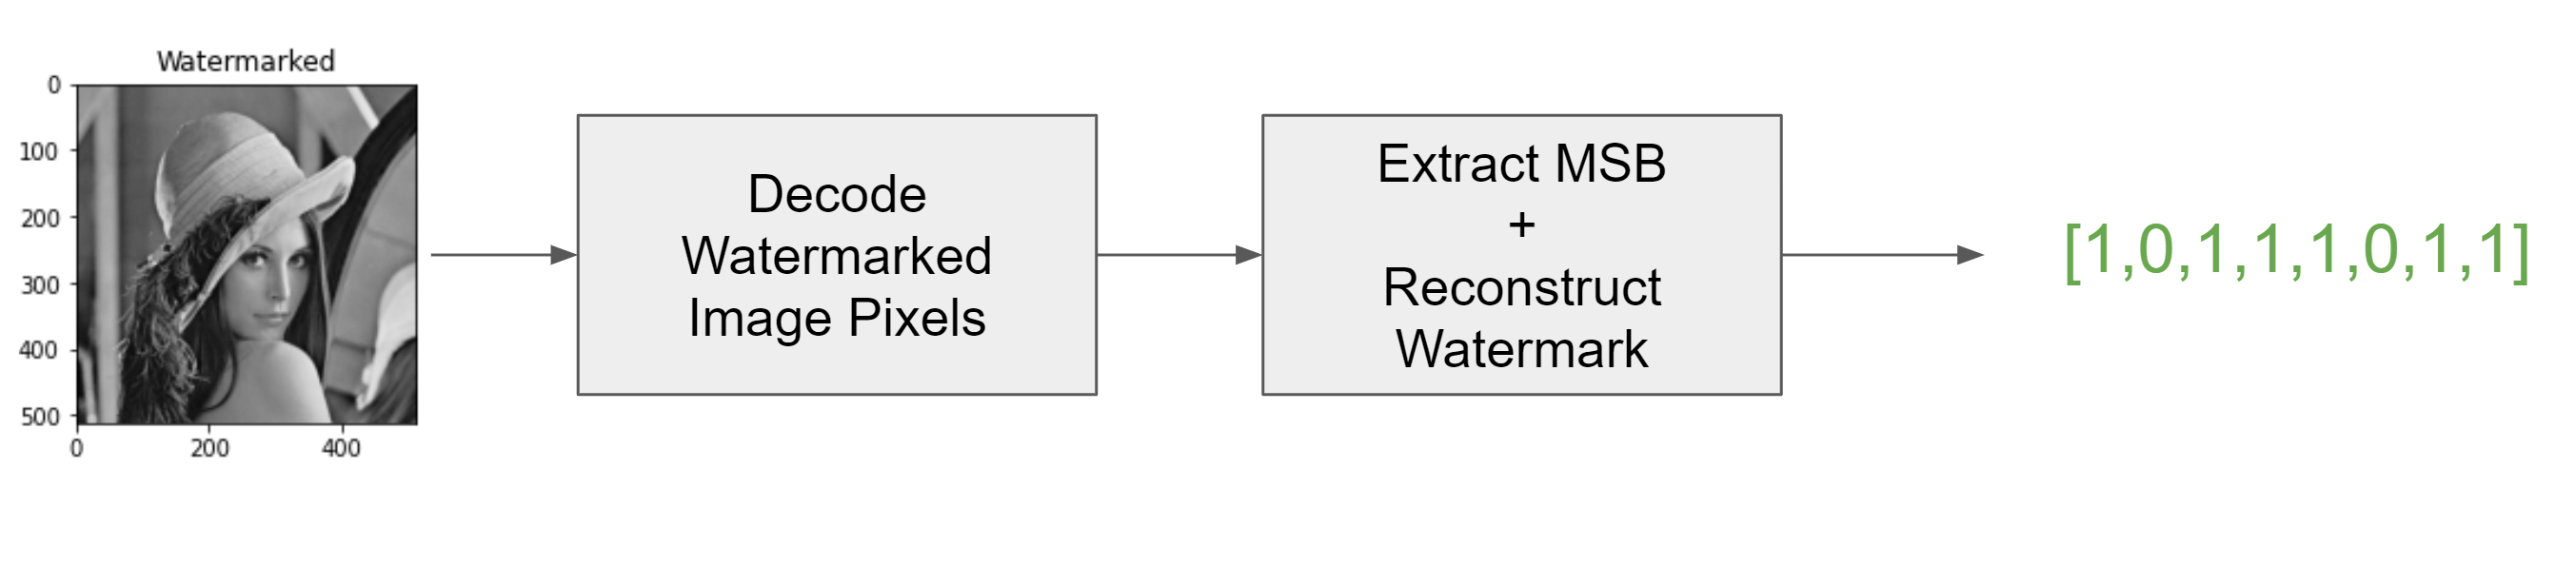

### Decode Watermarked Image Pixels into bytes + Extraxt MSB and reconstruct watermark

In [7]:
# Read the watermarked image and flatten it
watermarked = cv2.imread('watermarked.bmp', 0)
#move from a matrix to an array
watermarked = watermarked.flatten()
# Create empy flatten watermark array
extracted_watermarked = np.zeros(N)
for i in range(N):
  extracted_watermarked[i] = int(format(watermarked[i], "08b")[-1], 2) #[-1] locate the pixels LSB (i.e. the last position). If you embed the watermark in another position, change the value inside [] accordingly 


## Similarity between the Extracted Watermark and the Original Watermark

This is a simple script to measure how similar the extracted watermark is with the original one. 

You can use compute_thr() to estimate a threshold to detect the presence of the watermark, however, this is not how we will estimate the threshold for the challenge.

To estimate the similarity between $x$ (the watermark extracted from the watermarked image) and $x^\prime$ (the watermark extracted from the attacked watermarked image), we will use:

$sim(x,x^\prime)=\frac{x\cdot x^\prime}{||x||\cdot||x^\prime||}$

Threshold:  0.7177991358496321
Mark has been lost. SIM = 0.498055


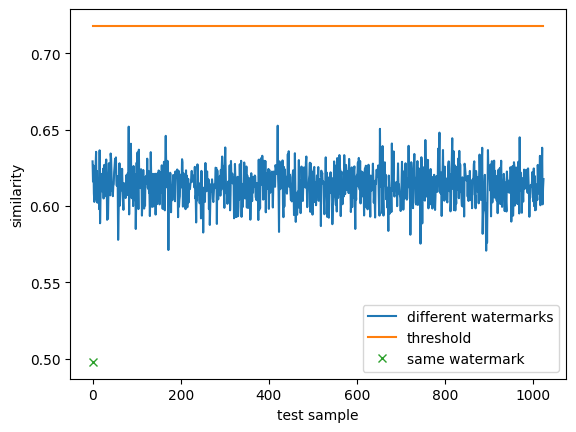

In [8]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('Threshold: ', T)
    return T, SIMs

sim = similarity(watermark, extracted_watermarked)
T, SIM_arr = compute_thr(sim, N, watermark, N)
plt.plot(SIM_arr, label='different watermarks')
plt.plot(np.ones(N)*T, label='threshold')
plt.plot(sim, 'x', label='same watermark')
plt.legend()
plt.ylabel('similarity')
plt.xlabel('test sample')


if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)
